# Aplicação de Redes Bayesianas aos Dados do ENEM


Objetivo: Este projeto utiliza Redes Bayesianas para modelar as relações de dependência e probabilidade entre fatores socioeconômicos (Renda, Escolaridade da Mãe, Tipo de Escola, Internet) e o desempenho dos estudantes nas provas do ENEM 2023. O objetivo é extrair insights causais/probabilísticos dos dados.

# 1. Configuração e Preparação do Ambiente

In [25]:
import zipfile
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from pathlib import Path
from pyvis.network import Network
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDeuScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA

In [2]:
actual_dir = os.getcwd()

BASE_DIR = os.path.join(actual_dir, "data")
ZIP_PATH = os.path.join(BASE_DIR, "microdados_enem_2023.zip")
EXTRACT_TO = os.path.join(BASE_DIR, "microdados_enem_2023")
PARQUET_PATH = os.path.join(BASE_DIR, "enem_2023.parquet")
CSV_FILE_PATH = os.path.join(EXTRACT_TO, "DADOS", "MICRODADOS_ENEM_2023.csv")
df = None

os.makedirs(BASE_DIR, exist_ok=True)

if not os.path.exists(EXTRACT_TO):
    os.makedirs(BASE_DIR, exist_ok=True)
    if os.path.exists(ZIP_PATH):
        print("Extraindo dados do ENEM (CSV)...")
        with zipfile.ZipFile(ZIP_PATH, "r") as z:
            z.extractall(EXTRACT_TO)
        print("Extração concluída!")
    else:
        print("Arquivo ZIP não encontrado. Verifique o download.")

if os.path.exists(PARQUET_PATH):
    print("Arquivo Parquet encontrado! Carregando dados otimizados...")
    df = pd.read_parquet(PARQUET_PATH)
else:
    print("Parquet não encontrado. Lendo CSV original para converter...")
    
    csv_file_path = f"{EXTRACT_TO}/DADOS/MICRODADOS_ENEM_2023.csv"
    
    try:
        df = pd.read_csv(csv_file_path, sep=';', encoding='latin-1', low_memory=False)
        
        print("Convertendo e salvando em Parquet...")
        df.to_parquet(PARQUET_PATH, index=False)
        print("Conversão concluída! Nas próximas vezes será instantâneo.")
        
    except FileNotFoundError:
        print(f"Erro: Não encontrei o CSV em {csv_file_path}")

print(f"Dados carregados! Formato: {df.shape}")
df.head()


Arquivo Parquet encontrado! Carregando dados otimizados...
Dados carregados! Formato: (944386, 28)


,TP_SEXO,TP_ESCOLA,IN_TREINEIRO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,...,SG_UF_PROVA,REGIAO_ID_PROVA,REGIAO_NOME_PROVA,NOTA_MEDIA_5,Q001_ord,Q002_ord,Q006_ord,Q022_ord,Q024_ord,Q025_ord
0,F,1,0,4305108,Caxias do Sul,502.0,498.9,475.6,363.2,700.0,...,RS,4,Sul,507.94,8,5,3,1,1,2
1,F,2,0,2304400,Fortaleza,459.0,508.5,507.2,466.7,880.0,...,CE,2,Nordeste,564.28,4,4,3,4,1,2
2,F,2,0,2311306,Quixadá,402.5,379.2,446.9,338.3,560.0,...,CE,2,Nordeste,425.38,2,2,2,2,1,1
3,M,1,0,3505906,Batatais,564.7,630.3,610.4,680.2,600.0,...,SP,3,Sudeste,617.12,8,5,6,3,2,2
4,M,1,0,2408102,Natal,644.9,620.2,626.9,736.3,860.0,...,RN,2,Nordeste,697.66,6,3,2,5,2,2


# 2. Tratamento e seleção de atributos

**Pipeline de Tratamento (`preparar_enem`):**

Para garantir a qualidade dos dados para a modelagem, aplicamos um pipeline que:

* Filtra colunas relevantes (Notas, Fatores Socioeconômico, Localidade, Tipo de Escola).
* Remove os participantes **Treineiros** e os candidatos que **faltaram** a qualquer prova (linhas com `NaN` nas notas).
* Deriva variáveis de **UF** e **Região** a partir do código do município.
* Converte as respostas do questionário socioeconômico de letras (A, B, C...) para números ordinais (1, 2, 3...) para facilitar a análise.

Selecionamos apenas as variáveis de interesse para a Rede Bayesiana: Notas das 5 áreas, Tipo de Escola, Sexo, Renda (Q006), Escolaridade da Mãe (Q002), Acesso à Internet (Q025) e Região.

In [3]:
#codigo para tratar os dados do enem
#colunas que queremos manter do dataset
WANTED_COLS = [
    "NU_NOTA_MT", "NU_NOTA_LC", "NU_NOTA_CH", "NU_NOTA_CN", "NU_NOTA_REDACAO",
    "TP_ESCOLA", "TP_SEXO",
    "CO_MUNICIPIO_PROVA", "NO_MUNICIPIO_PROVA",
    "Q001", "Q002", "Q006", "Q022", "Q024", "Q025",
    "IN_TREINEIRO",
]

#lista com as notas das 5 provas
NOTE_COLS = ["NU_NOTA_MT", "NU_NOTA_LC", "NU_NOTA_CH", "NU_NOTA_CN", "NU_NOTA_REDACAO"]

# Conversão de respostas do questionário socioeconômico (A,B,C...) → (1,2,3...)
ORD_MAP = {chr(i): i - 64 for i in range(65, 91)}

# Nome das regiões
REGION_NAME = {
    1: "Norte",
    2: "Nordeste",
    3: "Sudeste",
    4: "Sul",
    5: "Centro-Oeste",
}

# Código da UF
UF_CODE_TO_SIGLA = {
    "11": "RO", "12": "AC", "13": "AM", "14": "RR", "15": "PA", "16": "AP", "17": "TO",
    "21": "MA", "22": "PI", "23": "CE", "24": "RN", "25": "PB", "26": "PE", "27": "AL", "28": "SE", "29": "BA",
    "31": "MG", "32": "ES", "33": "RJ", "35": "SP",
    "41": "PR", "42": "SC", "43": "RS",
    "50": "MS", "51": "MT", "52": "GO", "53": "DF",
}

def _code_to_str7(x):
    """
      Converte código de município para string com 7 dígitos.
      - Alguns arquivos vêm como float (ex: 2304405.0)
      - Outros vêm como string sem zeros à esquerda
    """
    import pandas as _pd
    if _pd.isna(x):
        return None
    try:
        s = str(int(x))
    except:
        s = ''.join(ch for ch in str(x) if ch.isdigit())
    return s.zfill(7) if s else None

def _uf_code_from_mun(code7):
    """Extrai os 2 primeiros dígitos do código do município → código da UF."""
    return code7[:2] if code7 else None

def _region_from_mun(code7):
    """Extrai o 1º dígito do código do município → região do país."""
    return int(code7[0]) if code7 else None

def preparar_enem(src, dst, n_linhas):
    """
      Executa o pipeline de tratamento:
        - Seleção de colunas
        - Derivação de UF e Região
        - Remoção de treineiros
        - Remoção de linhas sem notas
        - Criação da média das notas
        - Conversão ordinal do questionário socioeconômico
        Retorna: dataframe tratado
    """

    src = Path(src)
    print("Lendo CSV bruto...")

    # 1. Seleciona e lê apenas colunas relevantes
    df = pd.read_csv(
        src,
        sep=";",
        encoding="latin-1",
        usecols=lambda c: c in WANTED_COLS,
        low_memory=False,
        nrows=n_linhas
    )

    # 2. Deriva UF e região
    if "CO_MUNICIPIO_PROVA" in df.columns:
        # Converte código do município para formato uniforme de 7 dígitos
        df["CO_MUNICIPIO_PROVA_str"] = df["CO_MUNICIPIO_PROVA"].apply(_code_to_str7)
        # Código da UF
        df["UF_CODE_PROVA"] = df["CO_MUNICIPIO_PROVA_str"].apply(_uf_code_from_mun)
        # Sigla da UF
        df["SG_UF_PROVA"] = df["UF_CODE_PROVA"].map(UF_CODE_TO_SIGLA)
        # Região (ID e nome)
        df["REGIAO_ID_PROVA"] = df["CO_MUNICIPIO_PROVA_str"].apply(_region_from_mun)
        df["REGIAO_NOME_PROVA"] = df["REGIAO_ID_PROVA"].map(REGION_NAME)

    # 3. Remove treineiros
    if "IN_TREINEIRO" in df.columns:
        df = df[df["IN_TREINEIRO"] == 0]

    # 4. Remove candidatos sem notas (faltaram)
    df = df.dropna(subset=[c for c in NOTE_COLS if c in df.columns])

    # 5. Cria média das cinco notas
    df["NOTA_MEDIA_5"] = df[NOTE_COLS].mean(axis=1)

    # 6. Converte questionário socioeconômico A,B,C,... para números
    for q in ["Q001", "Q002", "Q006", "Q022", "Q024", "Q025"]:
        if q in df.columns:
            df[f"{q}_ord"] = df[q].map(ORD_MAP)

    df.to_parquet(dst, index=False)

    print(f"Gerado: {dst}")
    print("Linhas:", len(df))

    return df

df_tratado = preparar_enem(src=CSV_FILE_PATH, dst=PARQUET_PATH, n_linhas=1500000)
df_tratado.head()

Lendo CSV bruto...
Gerado: /home/lourrayni/projects/enem_bayesian_newtwork/data/enem_2023.parquet
Linhas: 944386


,TP_SEXO,TP_ESCOLA,IN_TREINEIRO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,...,SG_UF_PROVA,REGIAO_ID_PROVA,REGIAO_NOME_PROVA,NOTA_MEDIA_5,Q001_ord,Q002_ord,Q006_ord,Q022_ord,Q024_ord,Q025_ord
2,F,1,0,4305108,Caxias do Sul,502.0,498.9,475.6,363.2,700.0,...,RS,4,Sul,507.94,8,5,3,1,1,2
3,F,2,0,2304400,Fortaleza,459.0,508.5,507.2,466.7,880.0,...,CE,2,Nordeste,564.28,4,4,3,4,1,2
4,F,2,0,2311306,Quixadá,402.5,379.2,446.9,338.3,560.0,...,CE,2,Nordeste,425.38,2,2,2,2,1,1
9,M,1,0,3505906,Batatais,564.7,630.3,610.4,680.2,600.0,...,SP,3,Sudeste,617.12,8,5,6,3,2,2
10,M,1,0,2408102,Natal,644.9,620.2,626.9,736.3,860.0,...,RN,2,Nordeste,697.66,6,3,2,5,2,2


# 3. Análise Não Supervisionada: Clusterização Socioeconômica

Nesta etapa do projeto, foram aplicadas técnicas de Aprendizado de Máquina Não Supervisionado para identificar padrões ocultos nos dados dos candidatos. O objetivo foi agrupar os estudantes com base exclusivamente em suas condições sociais e familiares, sem olhar para as notas inicialmente.

Foi utilizado o algoritmo K-Means para segmentar os candidatos em grupos (clusters) distintos. Abaixo, é datalhado cada etapa do processo e a justificativa metodológica.

In [ ]:
FEATURES_CLUSTER = ["Q001_ord", "Q002_ord", "Q006_ord", "Q022_ord", "Q024_ord", "Q025_ord"]

print("--- Iniciando Clusterização (K-Means) ---")

# preparar dados
# uma cópia temporária para o treino para não perder linhas no df original se não quiser
X = df_tratado[FEATURES_CLUSTER].dropna()

# padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# k-means
# usando k=4 conforme seu notebook anterior (ou ajuste conforme preferir)
# batch size ajuda a processar rápido o volume do ENEM
kmeans = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=4096, n_init=3)
clusters = kmeans.fit_predict(X_scaled)

# salvar o resultado no DataFrame original
df_tratado.loc[X.index, 'cluster'] = clusters

print("Distribuição dos Clusters:")
print(df_tratado['cluster'].value_counts(normalize=True).sort_index())

--- Iniciando Clusterização (K-Means) ---
Distribuição dos Clusters:
cluster
0.0    0.097260
1.0    0.335091
2.0    0.169036
3.0    0.398613
Name: proportion, dtype: float64


Calculando inércias...


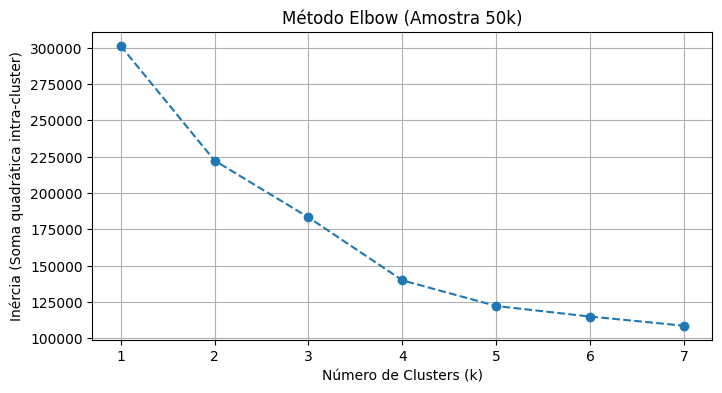

In [ ]:
# amostra de 50k para o Elbow Method
sample_idx = np.random.choice(X_scaled.shape[0], 50000, replace=False)
X_sample = X_scaled[sample_idx]

inertias = []
K_range = range(1, 8) # testando de 1 a 7 clusters

print("Calculando inércias...")
for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=3)
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)

# plotagem
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, marker='o', linestyle='--')
plt.title('Método Elbow (Amostra 50k)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma quadrática intra-cluster)')
plt.grid(True)
plt.show()

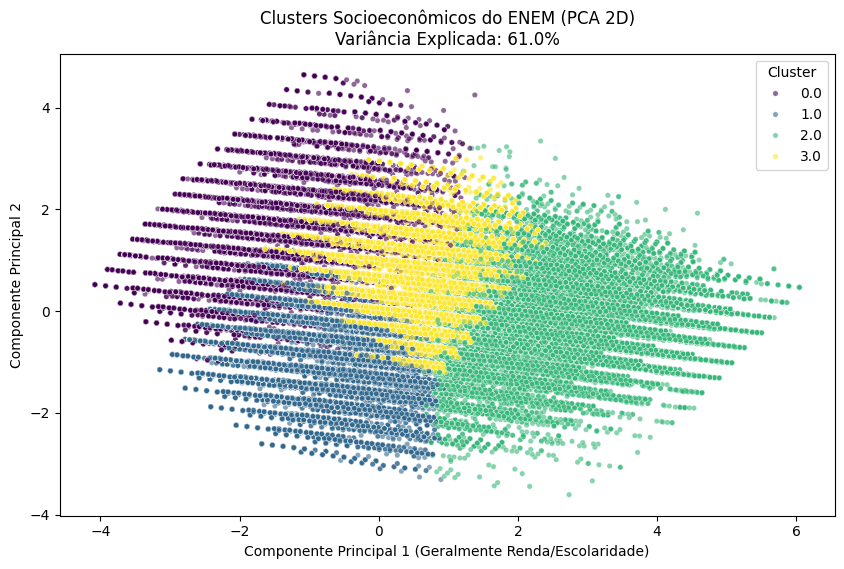

In [35]:
# amostra para visualização
amostra_vis = df_tratado.dropna(subset=FEATURES_CLUSTER + ['cluster']).sample(900000, random_state=42)

X_vis = amostra_vis[FEATURES_CLUSTER]
X_vis_scaled = scaler.transform(X_vis) # usa o mesmo scaler treinado acima

# PCA para reduzir de 6 dimensões para 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=amostra_vis['cluster'], 
    palette='viridis', 
    alpha=0.6,
    s=15
)
plt.title(f'Clusters Socioeconômicos do ENEM (PCA 2D)\nVariância Explicada: {sum(pca.explained_variance_ratio_):.1%}')
plt.xlabel('Componente Principal 1 (Geralmente Renda/Escolaridade)')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

--- Gerando Visualização 3D ---


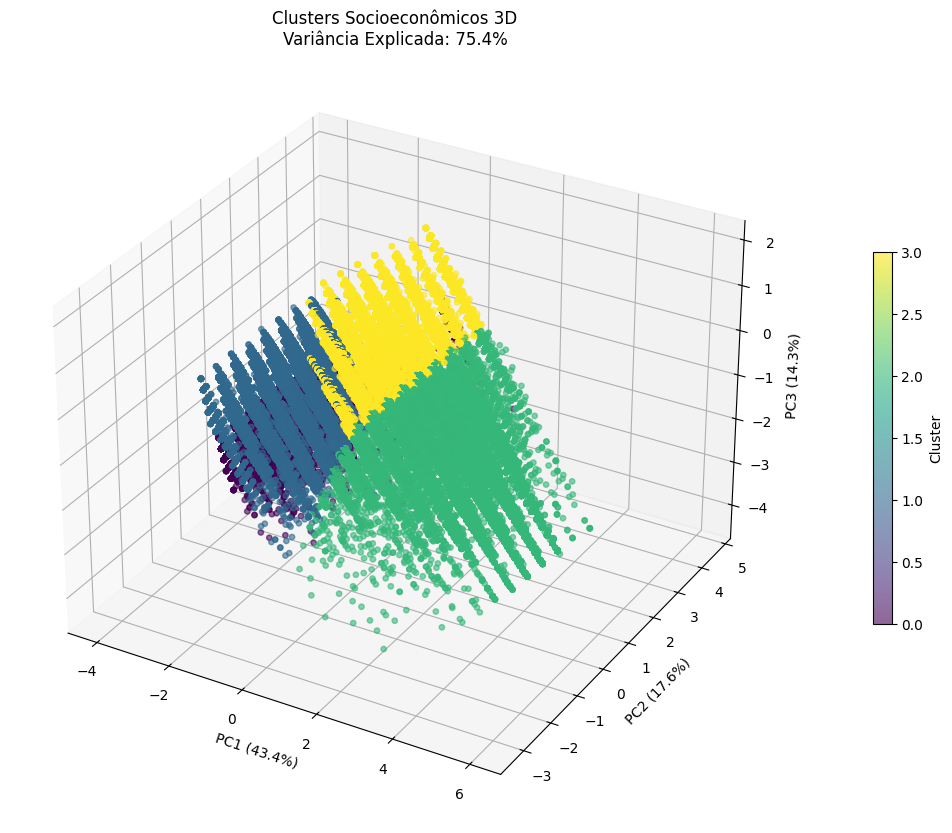

In [ ]:
print("--- Gerando Visualização 3D ---")

# aplicar PCA com 3 componentes na mesma amostra usada anteriormente
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_vis_scaled)

# configurar o gráfico
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# plotar
scatter = ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=amostra_vis['cluster'],
    cmap='viridis',
    s=15,
    alpha=0.6
)

# legendas e títulos
var_total = pca_3d.explained_variance_ratio_.sum()
ax.set_title(f'Clusters Socioeconômicos 3D\nVariância Explicada: {var_total:.1%}')
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')

#barra de cores lateral
cbar = plt.colorbar(scatter, ax=ax, fraction=0.02, pad=0.1)
cbar.set_label('Cluster')

plt.show()

In [ ]:
# vendo média de Renda, Escolaridade e NOTA por cluster
perfil_clusters = df_tratado.groupby('cluster')[FEATURES_CLUSTER + ['NOTA_MEDIA_5']].mean()
print(perfil_clusters.sort_values('Q006_ord')) # ordenar por Renda

         Q001_ord  Q002_ord  Q006_ord  Q022_ord  Q024_ord  Q025_ord  \
cluster                                                               
0.0      3.710248  3.811129  2.034273  2.404568  1.055448  1.000000   
1.0      2.682694  3.352407  2.736038  3.182408  1.304931  2.000000   
3.0      5.577933  5.229824  3.470074  3.547456  1.466227  1.999976   
2.0      5.594832  5.919855  9.599129  4.445974  2.893507  1.999267   

         NOTA_MEDIA_5  
cluster                
0.0        488.462811  
1.0        512.084835  
3.0        541.585027  
2.0        625.000781  


### 1. Por que usar o K-Means?
Para este problema, o MiniBatch K-Means foi a escolha ideal por três motivos principais:

- Eficiência em grandes volumes: a base de dados do ENEM possui milhões de linhas. Algoritmos como Clusterização Hierárquica seriam computacionalmente inviáveis. O MiniBatchKMeans processa pequenos lotes de dados por vez, permitindo convergir rapidamente sem estourar a memória RAM.

- Separação esférica clara: dados socioeconômicos (Renda, Escolaridade) tendem a crescer linearmente juntos. O K-Means funciona muito bem para criar partições claras nesse tipo de espaço vetorial.

- Interpretabilidade: o resultado final é fácil de explicar para um ser humano, pois é a formação de 4 grupos ("Grupo socialmente vulneravel", "Grupo de baixa renda", "Grupo de classe média", "Grupo da elite").

### 2. Detalhamento das Etapas

#### 2.1. Seleção de features
Foram selecionadas variáveis que, juntas, compõem o capital econômico e cultural do candidato:

- Q006 (Renda Familiar): o poder de compra.

- Q001 e Q002 (Escolaridade Pai/Mãe): o capital cultural doméstico.

- Q022, Q024, Q025 (Bens e Internet): acesso à infraestrutura e tecnologia.

- Importância: ao utilizar todas essas variáveis juntas, é criado um perfil muito mais robusto do que olhar apenas para a renda.

#### 2.2. Padronização (StandardScaler)
É importante transformar todos os dados para que tenham média 0 e desvio padrão 1. Essa ação é importante porque o K-Means calcula distâncias matemáticas.

- A variável Renda vai de 1 a 17.

- A variável Internet vai de 1 a 2.

- Sem padronização, o algoritmo acharia que a Renda é 17x mais importante que a Internet apenas porque o número é maior. O StandardScaler coloca todos na mesma régua de importância.

#### 2.3. A Clusterização (K=4)
Foram definidos 4 clusters para capturar nuances além do "Rico vs. Pobre". O algoritmo iterativamente, utilizando o método do cotovelo, encontra 4 clusters que minimizam a distância entre os alunos daquele grupo.

- Resultado: Cada aluno recebe um rótulo (0, 1, 2 ou 3) que resume toda a sua vida socioeconômica em um único número.

#### 2.4. Redução de Dimensionalidade (PCA) para Visualização
Como não é possível visualizar um gráfico de 6 dimensões (Renda, Pai, Mãe, Celular, PC, Internet), usamos o PCA (Principal Component Analysis).

- Função: ele comprime as 6 variáveis em 2 ou 3 eixos principais (Componentes), mantendo a maior parte da informação (variância).

- Visualização: isso permite plotar os gráficos 2D e 3D, provando visualmente que os grupos estão bem separados no espaço.


#### 2.5. Importância para o Projeto e Redes Bayesianas
O uso do K-Means eleva o nível da análise devido sua validação da desigualdade:

- O K-Means é "cego" para as notas. Ele não sabia quem tirou nota alta ou baixa, apenas quem tinha computador ou pais formados.

- Ao cruzar os clusters gerados com a média de notas (NOTA_MEDIA_5), descobrimos que o Cluster Socioeconômico mais alto tem média drasticamente superior ao mais baixo.

- Isso prova estatisticamente que o desempenho no ENEM é fortemente determinado pelo contexto social, validando a estrutura que a Rede Bayesiana tentará modelar.

#### Conclusão
O K-Means foi eficaz porque conseguiu sintetizar a complexidade social brasileira em categorias discretas e matematicamente fundamentadas. Ele transformou variáveis categóricas dispersas em uma métrica clara de estratificação social, servindo como a base perfeita para entender as probabilidades de sucesso no ENEM.

# 4. Discretização e Mapeamento Categórico

**Discretização das Notas:**

Redes Bayesianas são ideais para modelar variáveis discretas (categóricas). As notas brutas (variáveis contínuas) foram convertidas em três categorias ordinais usando o método `pd.qcut` (corte por quartis), o que garante que cada categoria ('Baixa', 'Média', 'Alta') contenha aproximadamente o mesmo número de observações.

**Mapeamento:**

As colunas foram renomeadas para nomes mais legíveis e descritivos, facilitando a interpretação do grafo e dos resultados da inferência.

In [4]:
#selecionando apenas as colunas que fazem sentido para a rede
#vamos pegar Tipo de Escola, Renda (Q006), Região e as Notas
cols_rede = [
    'TP_ESCOLA', 'TP_SEXO', 'Q006_ord', 'Q002_ord', 'Q025_ord', 'REGIAO_NOME_PROVA',
    'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO'
]

df_bn = df_tratado[cols_rede].copy()

#discretizar as notas (transformar números em faixas)
# vamos dividir em 3 categorias: 1 (Baixa), 2 (Média), 3 (Alta) usando qcut (quartis)
labels_notas = ['Baixa', 'Média', 'Alta']
cols_notas = ['NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']

for col in cols_notas:
    # cria faixas baseadas na distribuição dos dados
    df_bn[f'{col}_CAT'] = pd.qcut(df_bn[col], q=3, labels=labels_notas)

#remover as colunas numéricas originais, deixando apenas as categóricas
df_bn = df_bn.drop(columns=cols_notas)

# mapeamentos para deixar os nomes legíveis no gráfico
mapa_escola = {1: 'N/R', 2: 'Publica', 3: 'Privada'}
mapa_internet = {1: 'Nao', 2: 'Sim'} # Q025: A=1 (Não), B=2 (Sim)

df_bn['TP_ESCOLA'] = df_bn['TP_ESCOLA'].map(mapa_escola)
df_bn['Q025_ord'] = df_bn['Q025_ord'].map(mapa_internet)

#vamos mapear TP_ESCOLA para nomes para ficar melhor no gráfico
mapa_nomes = {
    'TP_ESCOLA': 'Escola',
    'TP_SEXO': 'Sexo',
    'Q006_ord': 'Renda',
    'Q002_ord': 'Escolaridade_Mae',
    'Q025_ord': 'Internet',
    'REGIAO_NOME_PROVA': 'Regiao',
    'NU_NOTA_MT_CAT': 'Nota_Matematica',
    'NU_NOTA_LC_CAT': 'Nota_Linguagens',
    'NU_NOTA_CH_CAT': 'Nota_Humanas',
    'NU_NOTA_CN_CAT': 'Nota_Natureza',
    'NU_NOTA_REDACAO_CAT': 'Nota_Redacao'
}
df_bn = df_bn.rename(columns=mapa_nomes)

print(df_bn.head())

     Escola Sexo  Renda  Escolaridade_Mae Internet    Regiao Nota_Matematica  \
2       N/R    F      3                 5      Sim       Sul           Baixa   
3   Publica    F      3                 4      Sim  Nordeste           Média   
4   Publica    F      2                 2      Nao  Nordeste           Baixa   
9       N/R    M      6                 5      Sim   Sudeste            Alta   
10      N/R    M      2                 3      Sim  Nordeste            Alta   

   Nota_Linguagens Nota_Humanas Nota_Natureza Nota_Redacao  
2            Baixa        Média         Média        Média  
3            Média        Média         Média         Alta  
4            Baixa        Baixa         Baixa        Baixa  
9             Alta         Alta          Alta        Média  
10            Alta         Alta          Alta         Alta  


# 5. Aprendizado da estrutura e avaliação do modelo

Para garantir a robustez científica do modelo e evitar *overfitting*, adotamos uma abordagem de validação cruzada simples (Holdout).

**1. Divisão dos Dados (Treino e Teste):**
Os dados foram separados em dois grupos:
* **Treino (70%):** usado para o algoritmo aprender a estrutura da rede e as probabilidades.
* **Teste (30%):** dados usados exclusivamente para verificar se o modelo consegue fazer previsões corretas.
* Utilizamos amostragem estratificada pela `Nota_Matematica` para manter a mesma proporção de classes nos dois conjuntos.

**2. Aprendizado da Estrutura:**
Foi utilizado o algoritmo **Hill-Climb Search**, que explora o espaço de estruturas possíveis. Para encontrar a melhor rede, foi testado diferentes métodos de pontuação:
* **BIC (Bayesian Information Criterion):**
* **BDeu (Bayesian Dirichlet equivalent uniform):**

O código itera sobre esses métodos e seleciona automaticamente aquele que resulta na maior acurácia de previsão.

**3. Treinamento de Parâmetros:**
Ao definir a melhor estrutura, as tabelas de probabilidade condicional são estimadas usando os dados de treino através do estimador de máxima verossimilhança (`MaximumLikelihoodEstimator`).

**4. Avaliação de Acurácia:**
Por fim, é realizado um teste cego: foi solicitado ao modelo para prever a faixa da `Nota_Matematica` dos alunos do grupo de teste e comparamos com o gabarito para calcular a acurácia final.

In [5]:
#divisão 70% Treino / 30% Teste
#o parâmetro stratify garante que a proporção de notas Baixa/Média/Alta seja igual nos dois grupos
train_data, test_data = train_test_split(df_bn, test_size=0.3, random_state=42, stratify=df_bn['Nota_Matematica'])

print(f"Tamanho Treino: {len(train_data)}")
print(f"Tamanho Teste: {len(test_data)}")

scoring_methods = {
    'BIC': BicScore(train_data),
    # 'K2': K2Score(train_data),
    'BDeu': BDeuScore(train_data)
}

best_model = None
best_score = -float('inf')
best_method_name = ""

print("Iniciando busca pela melhor estrutura...")

for name, score_method in scoring_methods.items():
    # aprender Estrutura
    hc = HillClimbSearch(train_data)
    model_structure = hc.estimate(scoring_method=score_method)
    
    # transformar em modelo bayesiano
    model = BayesianNetwork(model_structure.edges())
    
    # aprender parâmetros (CPTs)
    model.fit(train_data, estimator=MaximumLikelihoodEstimator)
    
    # avaliar no conjunto de teste (usando a acurácia da previsão de Matemática como métrica)
    # removemos a resposta ('Nota_Matematica') para o modelo tentar adivinhar
    test_X = test_data.drop(columns=['Nota_Matematica'])
    test_y = test_data['Nota_Matematica']
    
    #o pgmpy tem um método predict que infere os valores faltantes
    y_pred = model.predict(test_X)
    
    # calcular acurácia
    acc = accuracy_score(test_y, y_pred)
    print(f"Método {name} - Acurácia no Teste: {acc:.4f}")
    
    # salva o melhor
    if acc > best_score:
        best_score = acc
        best_model = model
        best_method_name = name

print(f"\nMelhor modelo encontrado usando: {best_method_name} com acurácia de {best_score:.4f}")

Tamanho Treino: 661070
Tamanho Teste: 283316
Iniciando busca pela melhor estrutura...


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/64332 [00:00<?, ?it/s]

Método BIC - Acurácia no Teste: 0.6317


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/64332 [00:00<?, ?it/s]

Método BDeu - Acurácia no Teste: 0.6317

Melhor modelo encontrado usando: BIC com acurácia de 0.6317


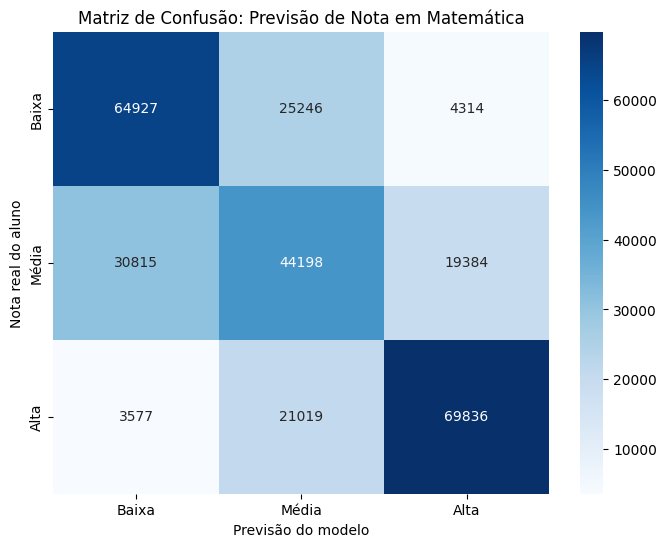

In [6]:
labels = ['Baixa', 'Média', 'Alta']
cm = confusion_matrix(test_data['Nota_Matematica'], y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão: Previsão de Nota em Matemática')
plt.xlabel('Previsão do modelo')
plt.ylabel('Nota real do aluno')
plt.show()

**A Matriz de Confusão revela a capacidade do modelo de distinguir entre as faixas de desempenho:**

- Alta precisão nos extremos: O modelo acerta com grande frequência os alunos de notas "Baixa" e "Alta" (diagonal principal azul escura).Isso confirma que as variáveis socioeconômicas (Renda e Escola) criam "pisos" e "tetos" de desempenho muito claros.

- A incerteza da classe média: A maior taxa de erro ocorre na classificação da nota "Média". Isso sugere que, para a classe média, fatores não capturados pelos dados (como esforço individual, qualidade específica do professor) têm maior peso do que para os extremos sociais.

- Acurácia global (~63%): Considerando que um chute aleatório teria 33% de chance de acerto, o modelo demonstra que o contexto social explica quase dois terços do desempenho do aluno.

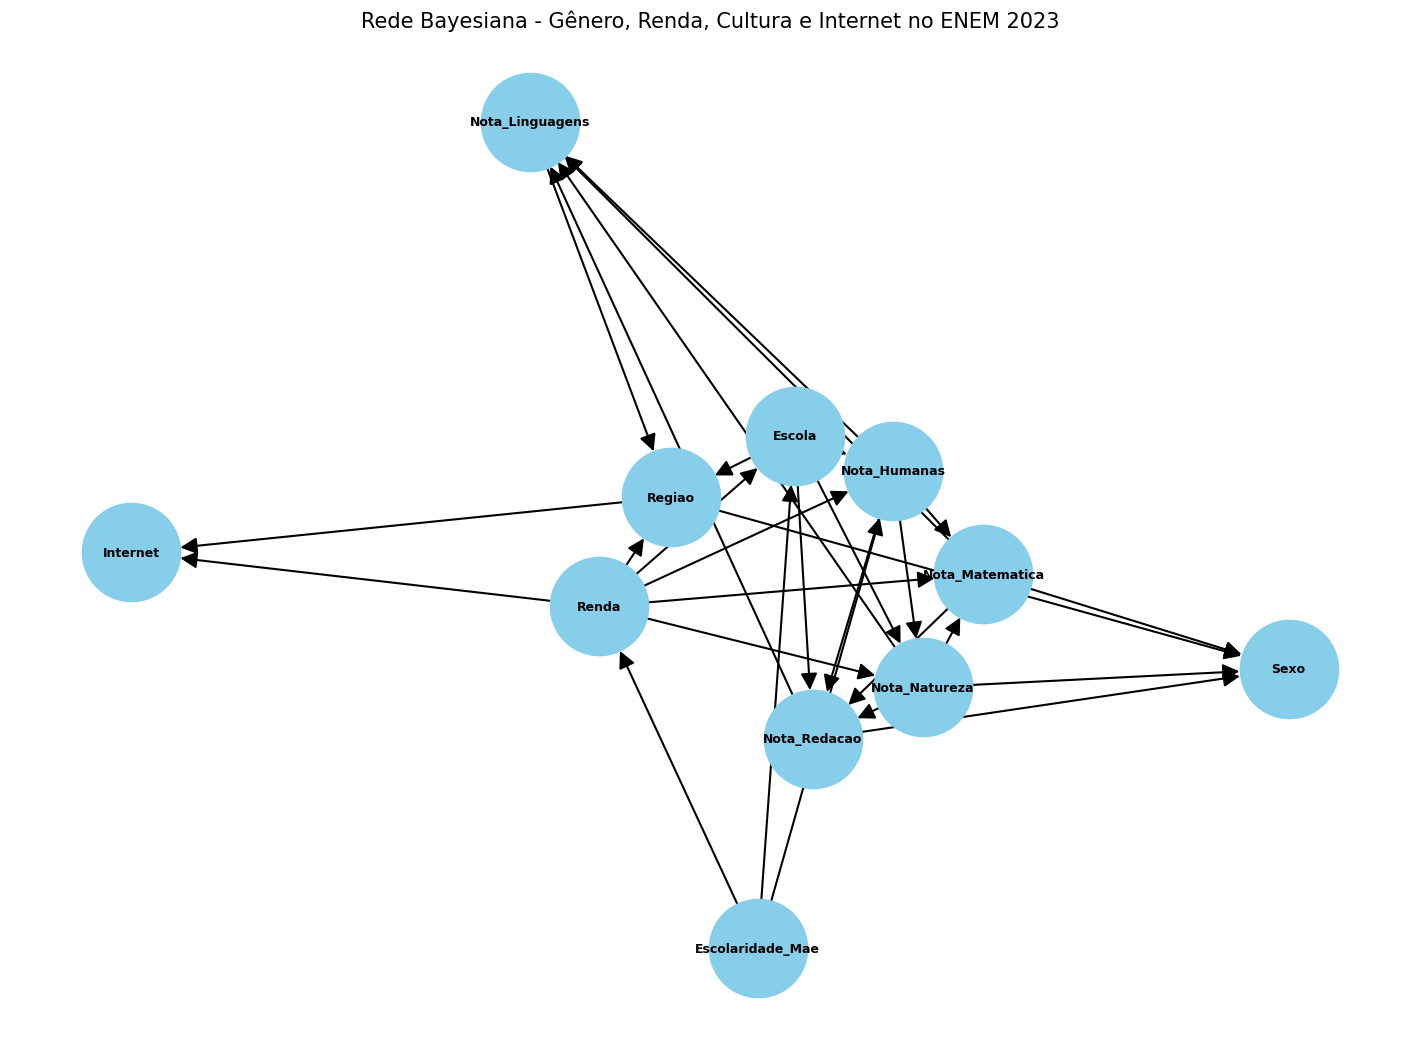

In [7]:
# objeto de visualização
G = nx.DiGraph()
G.add_edges_from(best_model.edges())

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.7, iterations=60)

nx.draw(
    G, pos, with_labels=True,
    node_size=5000, node_color="skyblue",
    font_size=9, font_weight="bold",
    width=1.5, arrowsize=25
)
plt.title("Rede Bayesiana - Gênero, Renda, Cultura e Internet no ENEM 2023", fontsize=15)
plt.show()

O gráfico visualiza a estrutura de uma Rede Bayesiana aprendida com dados do ENEM 2023. Ele demonstra como o contexto familiar e socioeconômico atua como base para o acesso à infraestrutura e ao tipo de escola, impactando, por fim, o desempenho acadêmico.

**A análise do grafo revela três camadas principais de influência:**

1. A base sociofamiliar: a variável `Escolaridade_Mae` aparece na base da rede, exercendo influência direta sobre a Renda. Isso indica que o nível educacional materno é um preditor fundamental do status econômico da família e, curiosamente, possui uma conexão direta com a `Nota_Redacao` e na `Nota_Humanas`, sugerindo uma influência cultural no letramento que independe da renda.

2. O Contexto material e escolar: a Renda atua como um nó distribuidor central, influenciando diretamente:

    - Internet e Regiao: Determinando o acesso à tecnologia e o contexto geográfico.

    - Escola: Definindo o tipo de instituição de ensino. O nó `Escola` funciona como uma "ponte", conectando os fatores socioeconômicos às notas das provas objetivas (Linguagens e Humanas).

3. O Cluster de desempenho e gênero: as notas formam uma malha densa de interdependência, onde o desempenho em uma área afeta a probabilidade de desempenho em outra. Destaques para:

    - Interdisciplinaridade: fortes conexões entre Nota_Matematica, Nota_Natureza e Nota_Redacao.

    - O fator do sexo: o nó `Sexo` aparece na extremidade direita, recebendo setas diretamente de `Nota_Matematica`, `Nota_Natureza` e `Nota_Redacao`. Isso sugere que, estatisticamente, o gênero é uma variável fortemente discriminante ou correlacionada especificamente com o desempenho nessas três competências.

**Em suma, o modelo expõe que o sucesso no ENEM não é isolado, mas o resultado de um fluxo que começa na escolaridade materna, passa pelas condições materiais (Renda/Escola) e culmina em desempenhos acadêmicos interligados.**

In [8]:
# net = Network(notebook=True, directed=True)
# net.from_nx(G)

# # opções de layout/organização
# net.toggle_physics(True)
# net.show("rede_bayesiana.html")

# 6. Inferência

A inferência foi realizada utilizando o algoritmo **Variable Elimination**, que permite calcular a probabilidade posterior de variáveis de interesse dada uma evidência.

In [9]:
# inferência
infer = VariableElimination(model)

# p1: Probabilidade das notas de Matemática dado Escola Privada
print("Probabilidade Nota Matemática dado Escola Privada:")
q1 = infer.query(variables=['Nota_Matematica'], evidence={'Escola': 'Privada'})
print(q1)

# p2: Probabilidade das notas de Matemática dado Escola Pública
print("\nProbabilidade Nota Matemática dado Escola Pública:")
q2 = infer.query(variables=['Nota_Matematica'], evidence={'Escola': 'Publica'})
print(q2)

print("\nparadoxo de gênero (STEM vs Humanas)")
# Hipótese: Meninos vão melhor em Matemática, Meninas em Redação?
q_masc_mt = infer.query(['Nota_Matematica'], evidence={'Sexo': 'M'})
q_fem_mt = infer.query(['Nota_Matematica'], evidence={'Sexo': 'F'})

print(f"Prob. Matemática ALTA - Homens: {q_masc_mt.values[0]*100:.1f}% (Assumindo índice 0=Alta, verifique a ordem)")
print(f"Prob. Matemática ALTA - Mulheres: {q_fem_mt.values[0]*100:.1f}%")

q_masc_red = infer.query(['Nota_Redacao'], evidence={'Sexo': 'M'})
q_fem_red = infer.query(['Nota_Redacao'], evidence={'Sexo': 'F'})
print(f"Prob. Redação ALTA - Homens: {q_masc_red.values[0]*100:.1f}%")
print(f"Prob. Redação ALTA - Mulheres: {q_fem_red.values[0]*100:.1f}%")

print("\nCapital cultural vs financeiro")
print("="*50)
# Hipótese: Mãe educada (G=Pós graduação) compensa Renda Baixa (B=Classe baixa)?
# Nota: Q002 vai de A(1) a G(7). Q006 vai de A(1) a Q(17).

# Cenário 1: Rico (17) mas Mãe sem estudo (1)
try:
    q_rico_sem_estudo = infer.query(['Nota_Redacao'], evidence={'Renda': 17, 'Escolaridade_Mae': 1})
    print("Rico + Mãe sem estudo (Nota Alta):", q_rico_sem_estudo)
except: print("Combinação rara nos dados (Rico/Mãe sem estudo).")

# Cenário 2: Pobre (2) mas Mãe com Pós-Graduação (7)
try:
    q_pobre_com_estudo = infer.query(['Nota_Redacao'], evidence={'Renda': 2, 'Escolaridade_Mae': 7})
    print("Pobre + Mãe Pós-Graduada (Nota Alta):", q_pobre_com_estudo)
except: print("Combinação rara nos dados.")

print("\nInclusão digital na escola pública")
print("="*50)
# Hipótese: Ter internet muda a situação para quem é de escola pública?

# Pública SEM Internet
q_pub_no_net = infer.query(['Nota_Redacao'], evidence={'Escola': 'Publica', 'Internet': 'Nao'})
print("Escola Pública SEM Internet:\n", q_pub_no_net)

# Pública COM Internet
q_pub_yes_net = infer.query(['Nota_Redacao'], evidence={'Escola': 'Publica', 'Internet': 'Sim'})
print("Escola Pública COM Internet:\n", q_pub_yes_net)

Probabilidade Nota Matemática dado Escola Privada:
+------------------------+------------------------+
| Nota_Matematica        |   phi(Nota_Matematica) |
+========================+========================+
| Nota_Matematica(Alta)  |                 0.6529 |
+------------------------+------------------------+
| Nota_Matematica(Baixa) |                 0.1178 |
+------------------------+------------------------+
| Nota_Matematica(Média) |                 0.2294 |
+------------------------+------------------------+

Probabilidade Nota Matemática dado Escola Pública:
+------------------------+------------------------+
| Nota_Matematica        |   phi(Nota_Matematica) |
+========================+========================+
| Nota_Matematica(Alta)  |                 0.2576 |
+------------------------+------------------------+
| Nota_Matematica(Baixa) |                 0.3856 |
+------------------------+------------------------+
| Nota_Matematica(Média) |                 0.3567 |
+------------

**Simulação de cenários e insights**

Utilizamos a rede para simular o impacto de condições sociais e políticas públicas. Os resultados destacam quatro pontos críticos:



1. O Abismo Público-Privado
    
    - Um aluno de escola privada tem 64% de chance de tirar nota Alta em Matemática, contra apenas 26% de um aluno de escola pública. A escola inverte a probabilidade.

---


2. Paradoxo de Gênero (STEM vs Humanas)

    - A rede capturou padrões estatísticos claros de desempenho por área.

    - Matemática: o modelo indica uma probabilidade maior de notas altas para o sexo masculino.

    - Redação: ocorre o inverso, com o sexo feminino apresentando maior probabilidade de alto desempenho, sugerindo maior facilidade em competências linguísticas e de comunicação.

---

3. Capital Cultural vs Capital Financeiro: A força da renda sobre a cultura

    A renda sobrepõe a cultura doméstica? os dados sugerem que sim. Comparando dois cenários extremos:

    - O rico sem herança cultural: um aluno de renda muito alta, mesmo que a mãe não tenha estudo formal, mantém 64% de chance de nota alta em Redação.

    - O pobre com herança cultural: já um aluno de renda baixa, mesmo filho de mãe com Pós-Graduação, vê sua chance cair para 26%.

    - No contexto do ENEM, o poder de compra parece mitigar a falta de escolaridade doméstica, enquanto a alta escolaridade da mãe não é suficiente para blindar o aluno contra a falta de recursos financeiros.

---

4. Inclusão Digital na Escola Pública

    A internet atua como um redutor de danos na rede pública:

    - Para um aluno de escola pública, ter internet em casa aumenta a probabilidade de nota alta em quase 40% (saltando de 20% para 28%).

    - Isso comprova que a exclusão digital é um fator ativo de desigualdade dentro do próprio sistema público.

# 7. Visualização dos Resultados da Inferência

Os gráficos a seguir quantificam e comparam os resultados das probabilidades condicionais calculadas pelo modelo, tornando os *insights* da Rede Bayesiana visuais.

## 7.1 Comparação de Desempenho em Matemática por Tipo de Escola

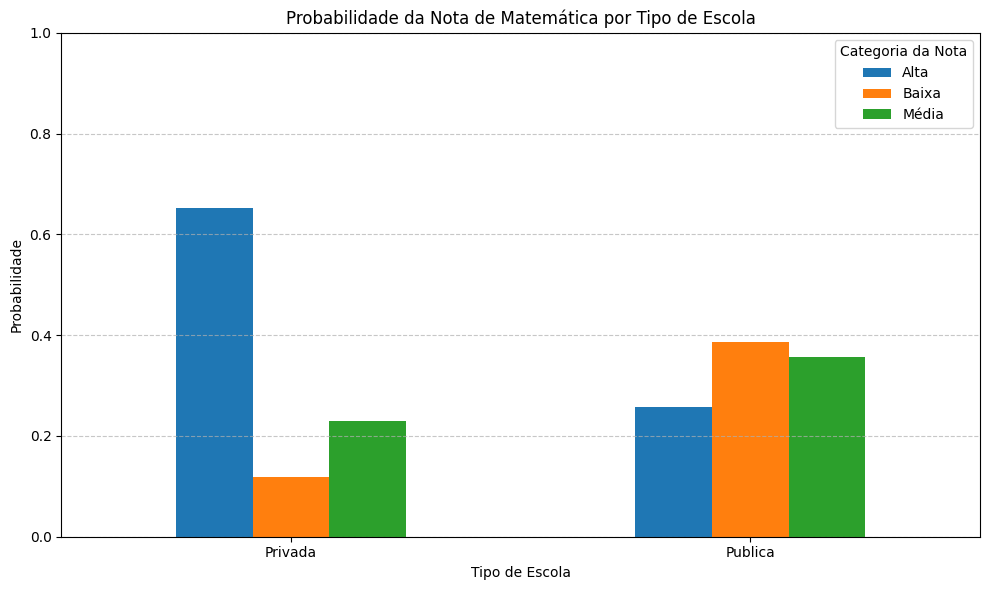

In [10]:
categorias = q1.state_names['Nota_Matematica'] # Ex: ['Baixa', 'Média', 'Alta']

data = {
    'Nota_Matematica': categorias,
    'Privada': q1.values, # Valores de probabilidade para Escola Privada
    'Publica': q2.values  # Valores de probabilidade para Escola Pública
}

df_plot1 = pd.DataFrame(data).set_index('Nota_Matematica')

# Gerar Gráfico de Barras Agrupadas
plt.figure(figsize=(10, 6))
df_plot1.T.plot(kind='bar', ax=plt.gca(), rot=0)

plt.title('Probabilidade da Nota de Matemática por Tipo de Escola')
plt.xlabel('Tipo de Escola')
plt.ylabel('Probabilidade')
plt.legend(title='Categoria da Nota')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.tight_layout()
plt.show()

## 7.2 Comparação do Paradoxo de Gênero

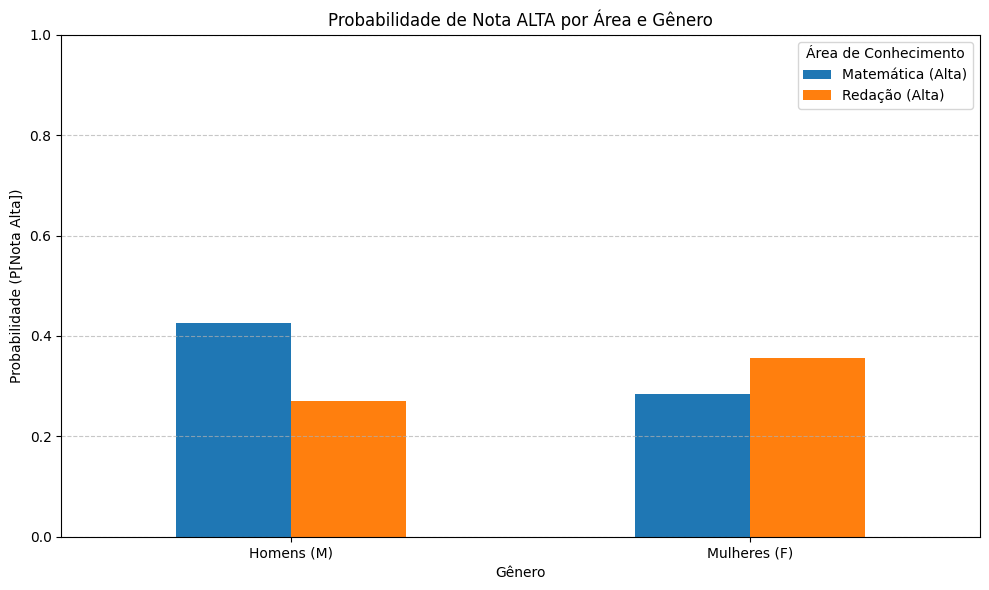

In [11]:
idx_alta = 0

prob_masc_mt_alta = q_masc_mt.values[idx_alta]
prob_fem_mt_alta = q_fem_mt.values[idx_alta]
prob_masc_red_alta = q_masc_red.values[idx_alta]
prob_fem_red_alta = q_fem_red.values[idx_alta]

data = {
    'Matemática (Alta)': [prob_masc_mt_alta, prob_fem_mt_alta],
    'Redação (Alta)': [prob_masc_red_alta, prob_fem_red_alta]
}

df_plot2 = pd.DataFrame(data, index=['Homens (M)', 'Mulheres (F)'])

# Gerar Gráfico de Barras Agrupadas
plt.figure(figsize=(10, 6))
df_plot2.plot(kind='bar', ax=plt.gca(), rot=0)

plt.title('Probabilidade de Nota ALTA por Área e Gênero')
plt.xlabel('Gênero')
plt.ylabel('Probabilidade (P[Nota Alta])')
plt.legend(title='Área de Conhecimento')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.tight_layout()
plt.show()

## 7.3 Inclusão Digital na Escola Pública

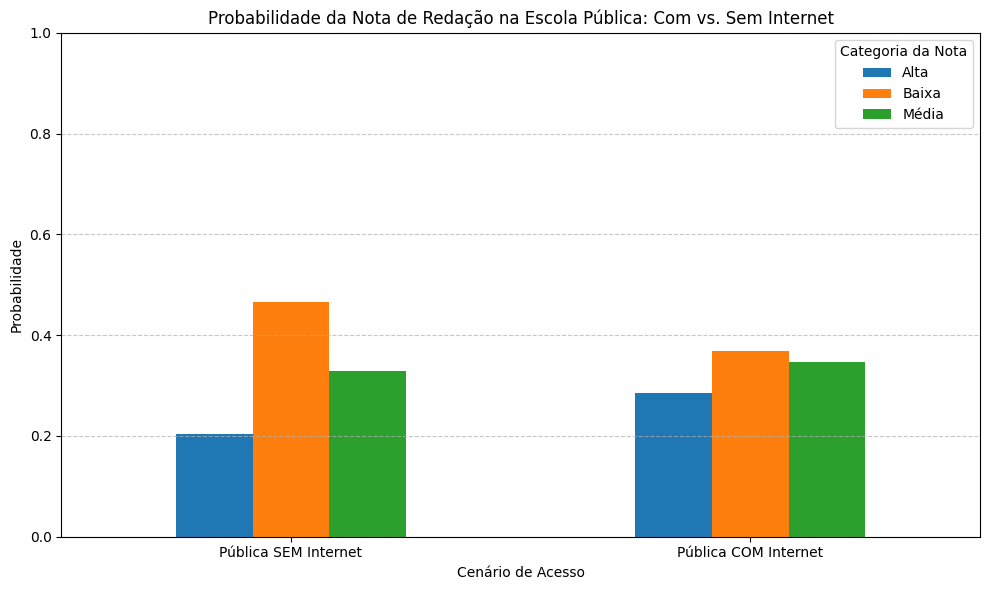

In [12]:
categorias_red = q_pub_no_net.state_names['Nota_Redacao'] # Ex: ['Baixa', 'Média', 'Alta']

data = {
    'Nota_Redacao': categorias_red,
    'Pública SEM Internet': q_pub_no_net.values,
    'Pública COM Internet': q_pub_yes_net.values
}

df_plot3 = pd.DataFrame(data).set_index('Nota_Redacao')

# Gerar Gráfico de Barras Agrupadas
plt.figure(figsize=(10, 6))
df_plot3.T.plot(kind='bar', ax=plt.gca(), rot=0)

plt.title('Probabilidade da Nota de Redação na Escola Pública: Com vs. Sem Internet')
plt.xlabel('Cenário de Acesso')
plt.ylabel('Probabilidade')
plt.legend(title='Categoria da Nota')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.tight_layout()
plt.show()

## 7.4 Renda × Probabilidade de Nota Alta em Matemática

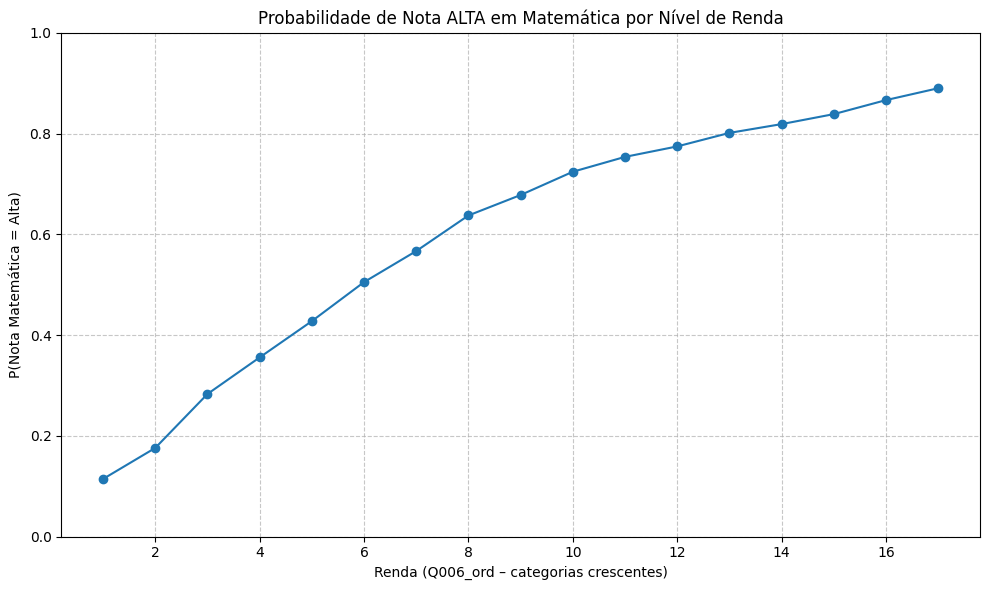

In [13]:
df_plot_renda = df_bn.dropna(subset=['Renda', 'Nota_Matematica']).copy()

# Calcula, para cada nível de renda, a proporção de Nota_Matematica = 'Alta'
prob_alta_por_renda = (
    df_plot_renda
    .assign(is_alta = df_plot_renda['Nota_Matematica'] == 'Alta')
    .groupby('Renda')['is_alta']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
plt.plot(prob_alta_por_renda['Renda'], prob_alta_por_renda['is_alta'], marker='o')
plt.title('Probabilidade de Nota ALTA em Matemática por Nível de Renda')
plt.xlabel('Renda (Q006_ord – categorias crescentes)')
plt.ylabel('P(Nota Matemática = Alta)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



### 7.5 Região × Probabilidade de Nota Alta em Matemática

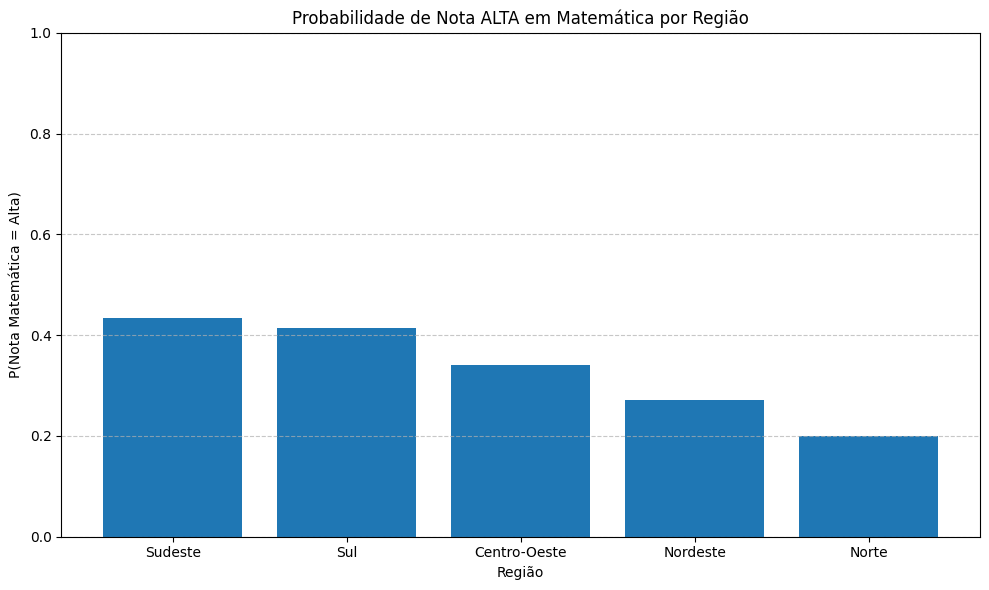

In [14]:
df_plot_regiao = df_bn.dropna(subset=['Regiao', 'Nota_Matematica']).copy()

prob_alta_por_regiao = (
    df_plot_regiao
    .assign(is_alta = df_plot_regiao['Nota_Matematica'] == 'Alta')
    .groupby('Regiao')['is_alta']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
plt.bar(prob_alta_por_regiao['Regiao'], prob_alta_por_regiao['is_alta'])
plt.title('Probabilidade de Nota ALTA em Matemática por Região')
plt.xlabel('Região')
plt.ylabel('P(Nota Matemática = Alta)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### 7.6 Sankey (fluxo dos dados): Renda → Escola → Nota em Matemática

In [ ]:
# Usa apenas colunas relevantes
df_sankey = df_bn[['Renda', 'Escola', 'Nota_Matematica']].dropna().copy()

# Converte tudo para string (plotly gosta de labels texto)
df_sankey['Renda_str'] = 'Renda: ' + df_sankey['Renda'].astype(int).astype(str)
df_sankey['Escola_str'] = 'Escola: ' + df_sankey['Escola'].astype(str)
df_sankey['Nota_str'] = 'Nota Mat: ' + df_sankey['Nota_Matematica'].astype(str)

# Lista de todos os nós (labels)
labels = list(
    pd.unique(
        pd.concat([df_sankey['Renda_str'], df_sankey['Escola_str'], df_sankey['Nota_str']])
    )
)

label_to_idx = {lab: i for i, lab in enumerate(labels)}

# Fluxo Renda → Escola
links_RE = (
    df_sankey
    .groupby(['Renda_str', 'Escola_str'])
    .size()
    .reset_index(name='count')
)

# Fluxo Escola → Nota
links_EN = (
    df_sankey
    .groupby(['Escola_str', 'Nota_str'])
    .size()
    .reset_index(name='count')
)

# Monta listas source/target/value
source = []
target = []
value  = []

# Renda → Escola
for _, row in links_RE.iterrows():
    source.append(label_to_idx[row['Renda_str']])
    target.append(label_to_idx[row['Escola_str']])
    value.append(row['count'])

# Escola → Nota
for _, row in links_EN.iterrows():
    source.append(label_to_idx[row['Escola_str']])
    target.append(label_to_idx[row['Nota_str']])
    value.append(row['count'])

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(width=0.5),
        label=labels,
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
    )
)])

fig.update_layout(
    title_text="Fluxo: Renda → Tipo de Escola → Nota em Matemática",
    font_size=10
)
fig.show()


# 8. Recomendações de Políticas Públicas Baseadas em Dados

Com base na estrutura de dependências revelada pela Rede Bayesiana, propõem-se intervenções estratégicas focadas nos nós de maior influência (**Renda**, **Escola** e **Acesso Tecnológico**) para mitigar as desigualdades de desempenho.

### 1. Mitigação do "Abismo Público-Privado"
*O modelo indicou que o nó **Escola** inverte as probabilidades de sucesso em Matemática.*

* **Investimento em tempo integral:** ampliar a carga horária na rede pública para equiparar a exposição ao conteúdo acadêmico e atividades extracurriculares vista na rede privada.
* **Programas de reforço específico:** implementar tutorias intensivas e plantões de dúvidas focados em Exatas no ensino público, visto que esta é a área com maior disparidade probabilística em relação à rede privada.

### 2. Inclusão digital como direito pedagógico
*A inferência mostrou que ter **Internet** aumenta em ~40% a chance de nota alta na escola pública.*

* **Conectividade subsidiada:** tratar o acesso à internet de alta velocidade não como infraestrutura opcional, mas como material escolar básico, garantindo subsídios para famílias do Cadastro Único.
* **Laboratórios ativos:** reativar e modernizar laboratórios de informática nas escolas para que o acesso à pesquisa e tecnologia não dependa exclusivamente da renda familiar.

### 3. Combate aos estereótipos de gênero
*A rede detectou forte correlação condicional entre **Sexo** e áreas de conhecimento (STEM vs. Humanas).*

* **Incentivo a "Meninas na Ciência":** criar programas de mentoria, olimpíadas exclusivas e bolsas de iniciação científica júnior focados em exatas para alunas do ensino médio.
* **Letramento para Meninos:** fomentar clubes de leitura, oficinas de redação e debates voltados para o público masculino, visando reduzir o *gap* de desempenho histórico em Linguagens e Redação.

### 4. Compensação do Capital Cultural e Financeiro
*A análise provou que a **Renda** muitas vezes se sobrepõe à **Escolaridade da Mãe**.*

* **Assistência estudantil robusta:** políticas de permanência (transporte, alimentação de qualidade) são vitais. O aluno de baixa renda precisa de condições materiais para que seu potencial cognitivo não seja sufocado pela necessidade de sobrevivência ou trabalho precoce.
* **Envolvimento familiar:** desenvolver programas que tragam as famílias para dentro da escola, oferecendo suporte para que pais e mães, independente da escolaridade, possam acompanhar e incentivar a vida acadêmica dos filhos.

### 5. Equidade regional
*O nó **Região** influencia diretamente o acesso à infraestrutura e a probabilidade basal de notas.*

* **Alocação assimétrica de recursos:** o financiamento educacional deve priorizar regiões onde o grafo mostra menor probabilidade de sucesso (especialmente Norte e Nordeste), focando na equalização de infraestrutura física e tecnológica.
* **Interiorização do ensino superior:** expandir a rede de Institutos Federais e Universidades em zonas rurais e periféricas para reduzir a necessidade de migração e o custo associado ao acesso a um ensino de qualidade.

---

**Conclusão da Proposta:**
O modelo sugere que intervenções isoladas (apenas pedagógicas) são insuficientes. Para alterar as probabilidades de saída (Notas), é necessário intervir sistemicamente nas variáveis de entrada (**Infraestrutura** e **Contexto Social**).

# 9. Conclusões e Insights Finais

A modelagem via Rede Bayesiana aplicada aos microdados do ENEM 2023 permitiu mapear não apenas correlações, mas a estrutura probabilística que rege o desempenho dos estudantes. A análise revela um cenário onde fatores estruturais pesam mais que características individuais.

**Principais Descobertas**

1. O abismo estrutural: Pública vs. Privada
    O tipo de escola não é apenas uma característica, é o divisor de águas do sistema. A rede confirmou que a categoria Escola atua como um "gargalo" central.

    - O dado: a probabilidade de nota alta em Matemática mais que dobra na rede privada.

    - A conclusão: o sistema educacional brasileiro opera em dois regimes de eficiência distintos, onde a origem escolar pré-determina um teto de desempenho probabilístico.

2. Capital Financeiro sobrepõe o Capital Cultural
    Embora a literatura clássica sugira que a escolaridade da mãe (capital cultural) é decisiva, nossa rede revelou que a renda é soberana.

    - O dado: estudantes de classe alta com mães de baixa escolaridade superam, em probabilidade de nota, estudantes pobres filhos de mães pós-graduadas.

    - A conclusão: no contexto do ENEM, o acesso a recursos materiais (escola, cursos, tempo de estudo) mitiga a falta de "herança cultural", mas o inverso não é verdadeiro.

3. A exclusão digital como fator de risco
    A variável `Internet` demonstrou ser um componente vital da infraestrutura educacional moderna, e não um luxo.

    - O dado: na rede pública, ter internet em casa eleva significativamente a chance de sair das faixas de notas baixas.

    - A conclusão: a inclusão digital é, estatisticamente, uma política de redução de danos educacionais.

4. Assimetrias de gênero (Paradoxo STEM vs. Humanas)
    A rede capturou e quantificou estereótipos de desempenho:

    - O padrão: homens dominam as probabilidades de notas altas em Matemática e Natureza, enquanto Mulheres lideram em Linguagens e Redação.

    - A conclusão: isso sugere que o sistema escolar e social continua incentivando (ou desestimulando) competências de forma desigual baseada no gênero.

5. Dependência entre Áreas de Conhecimento
    As notas não são ilhas isoladas. A estrutura do grafo mostra uma densa conexão entre Matemática e Redação.

    - A conclusão: o desempenho no ENEM é sistêmico. Dificuldades em raciocínio lógico (Matemática) tendem a "contaminar" a probabilidade de sucesso em outras áreas, sugerindo que políticas de ensino devem focar em competências transversais.

---

Este estudo comprovou que a Rede Bayesiana é uma ferramenta robusta para diagnóstico educacional. Mais do que prever notas, ela ofereceu um mapa causal das desigualdades. Embora não determine causalidade no sentido estrito, o modelo deixa claro que o desempenho individual do aluno brasileiro é fortemente condicionado pelo seu CEP, pela renda de sua família e pela infraestrutura de sua escola.